#Anomaly Detection of Network Packets

This is a task from http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html about network traffic packets. There are several kinds of preclassified packets: normal, trojans, viruses, etc.

The goal of this work to implement a detector of no normal = anomaly packets.



## Preparing data

In [ ]:
  !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

--2021-11-20 08:18:50--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  1.56MB/s    in 1.3s    

2021-11-20 08:18:52 (1.56 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]



In [ ]:
!gzip -d /content/kddcup.data_10_percent.gz

In [ ]:
col_labels = [
  'back',
  'buffer_overflow',
  'ftp_write',
  'guess_passwd',
  'imap',
  'ipsweep',
  'land',
  'loadmodule',
  'multihop',
  'neptune',
  'nmap',
  'normal',
  'perl',
  'phf',
  'pod',
  'portsweep',
  'rootkit',
  'satan',
  'smurf',
  'spy',
  'teardrop',
  'warezclient']

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

In [ ]:
import pandas as pd

In [ ]:
file_path = '/content/kddcup.data_10_percent'
df = pd.read_csv(file_path, header=None, names=col_names, index_col=False)
df.head

<bound method NDFrame.head of         duration protocol_type  ... dst_host_srv_rerror_rate    label
0              0           tcp  ...                      0.0  normal.
1              0           tcp  ...                      0.0  normal.
2              0           tcp  ...                      0.0  normal.
3              0           tcp  ...                      0.0  normal.
4              0           tcp  ...                      0.0  normal.
...          ...           ...  ...                      ...      ...
494016         0           tcp  ...                      0.0  normal.
494017         0           tcp  ...                      0.0  normal.
494018         0           tcp  ...                      0.0  normal.
494019         0           tcp  ...                      0.0  normal.
494020         0           tcp  ...                      0.0  normal.

[494021 rows x 42 columns]>

In [ ]:
print(df['label'].value_counts())

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: label, dtype: int64


In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df.label)

print(le.classes_)

['back.' 'buffer_overflow.' 'ftp_write.' 'guess_passwd.' 'imap.'
 'ipsweep.' 'land.' 'loadmodule.' 'multihop.' 'neptune.' 'nmap.' 'normal.'
 'perl.' 'phf.' 'pod.' 'portsweep.' 'rootkit.' 'satan.' 'smurf.' 'spy.'
 'teardrop.' 'warezclient.' 'warezmaster.']


In [ ]:
col_categories = ['protocol_type', 
                  'service', 
                  'flag', 
                  'land', 
                  'logged_in', 
                  'is_host_login', 
                  'is_guest_login']

In [ ]:
# just checking how data looks like
print(df['service'].value_counts())

ecr_i      281400
private    110893
http        64293
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
pm_dump         1
tftp_u          1
red_i           1
Name: service, Length: 66, dtype: int64


In [ ]:
# sample: protocol ("http", "ftp", "smtp")

#abc.protocol = "http"
#edf.protocol = "smtp"

# sample | is_http | is_ftp | is_smtp
#-----------------------------------------
# abc.      1.         0.        0 
# edf.      0.         0.        1


# do one-hot encoding for the symbolic data
cat_data = pd.get_dummies(df[col_categories])
cat_data.head(10)

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# exclude symbolic columns from the original dataset

col_numerics = list(set(df.columns.values) - set(col_categories))

In [ ]:
print(col_numerics)
col_numerics.remove('label')

['dst_host_serror_rate', 'srv_count', 'count', 'num_outbound_cmds', 'dst_host_count', 'num_access_files', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_rerror_rate', 'num_file_creations', 'urgent', 'dst_host_diff_srv_rate', 'wrong_fragment', 'srv_diff_host_rate', 'same_srv_rate', 'num_shells', 'dst_host_srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_srv_diff_host_rate', 'srv_serror_rate', 'dst_host_srv_rerror_rate', 'num_compromised', 'su_attempted', 'dst_host_same_src_port_rate', 'hot', 'label', 'dst_bytes', 'serror_rate', 'root_shell', 'num_root', 'src_bytes', 'rerror_rate', 'srv_rerror_rate', 'duration', 'num_failed_logins']


In [ ]:
# and add one-hot-encoded columns
numerics_data = df[col_numerics].copy()
numerics_cat_data = pd.concat([numerics_data, cat_data] ,axis=1)

In [ ]:
labels = df['label'].copy()
transormed_labels = le.transform(labels)

In [ ]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,9,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.0,0.0,1.0,0.0,0.00,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,5,0.00,0.00,0.0,0.0,1.0,0.0,0.40,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.0,0.0,1.0,0.0,0.00,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,18,0.17,0.11,0.0,0.0,1.0,0.0,0.17,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,12,0.00,0.00,0.0,0.0,1.0,0.0,0.17,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split dataset (with applied transforms) + labels 
# into train/test with 75% ratio

X_train, X_test, Y_train, Y_test = train_test_split(
    numerics_cat_data,
    transormed_labels,
    test_size = 0.25,
    random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(370515, 118)
(123506, 118)
(370515,)
(123506,)


In [ ]:
import pickle

In [ ]:
preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test,
    'le': le
}

pickle_path = '/content/kddcup.data_10_percent.pkl'
with open(pickle_path, 'wb') as f:
  pickle.dump(preprocessed_data, f)

## 1. Random Forest (multiclass) approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
model = RandomForestClassifier(n_estimators=300) 
model.fit(X_train, Y_train) 

RandomForestClassifier(n_estimators=300)

In [ ]:
from sklearn import tree
from os import system

estimator = model.estimators_[0] 
feature_names = [i for i in x_train.columns] 

tree.export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names, 
                rounded = True, 
                filled = True) 
 
#system.call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600']) 
 
#Image(filename = 'tree.png') 


In [ ]:
!dot -Tpng tree.dot -o tree.png

In [ ]:
y_predict = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
y_predict

array([ 5,  5,  5, ...,  5, 11, 11])

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


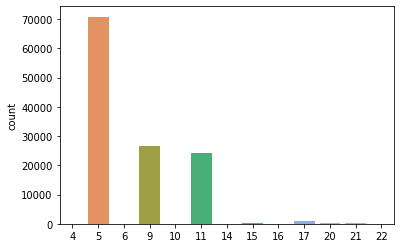

In [ ]:
sns.countplot(y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [ ]:
print(matr)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     1     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [  149 70651     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0 26709     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0    21     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [23599   734     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0    45     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0   285     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [   14     0     0     0     0     0     0     0 

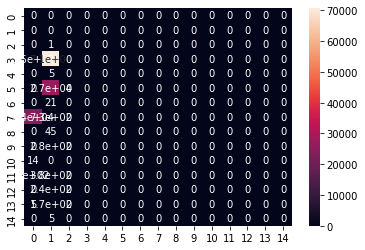

In [ ]:
matr = confusion_matrix(y_predict, y_test)
sn.heatmap(matr, annot=True)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

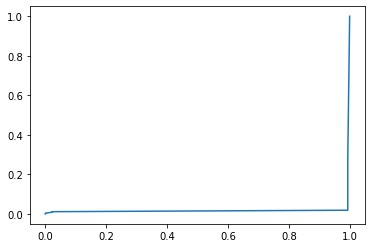

In [ ]:
roc_auc_score(y_test, y_predict)
fpr, tpr, thr = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)

In [ ]:
m = 10
temp = 0
for i in range(fpr.size):
    if (fpr[i] ** 2 + (tpr[i] - 1) ** 2 < m):
        m = fpr[i] ** 2 + (tpr[i] - 1) ** 2
        temp = i
print("OPTIMAL POINTS: ",fpr[temp],tpr[temp],thr[temp])

OPTIMAL POINTS:  0.0 0.7144973246405143 14


In [ ]:
y_predict

array([18, 18, 18, ..., 18, 11, 11])

In [ ]:
print(set(y_predict))

{0, 5, 9, 11, 14, 15, 17, 18, 20}


In [ ]:
y_test

array([1., 1., 1., ..., 1., 0., 0.], dtype=float32)

## Random Forest binary classes approach

In [ ]:
y_train

array([1., 0., 1., ..., 1., 0., 1.], dtype=float32)

In [ ]:
y_test

array([1., 1., 1., ..., 1., 0., 0.], dtype=float32)

In [ ]:
model = RandomForestClassifier(n_estimators=300) 
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [ ]:
y_predcit = model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


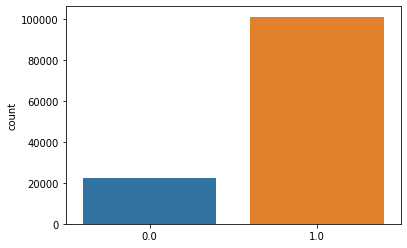

In [ ]:
sns.countplot(y_predcit)

In [ ]:
matr = confusion_matrix(y_predcit, y_test)
matr

array([[21586,   672],
       [ 2681, 98567]])

In [ ]:
accuracy_score(y_test, y_predcit)

0.9728515213835766

## 2. GAN approach

In [ ]:
import pickle

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import collections

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras import Model

# https://github.com/tqdm/tqdm
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
# load data back from pickle file:
pickle_file = '/content/kddcup.data_10_percent.pkl'
with open(pickle_file, 'rb') as f:
    preprocessed_data = pickle.load(f)

# check what's inside:
for key in preprocessed_data:
  print (key)

x_train
x_test
y_train
y_test
le


In [ ]:
le = preprocessed_data["le"]
x_train = preprocessed_data["x_train"]
y_train = preprocessed_data["y_train"]
x_test = preprocessed_data["x_test"]
y_test = preprocessed_data["y_test"]

In [ ]:
# lets identify what results do we actually have in labels..
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17,
       18, 20, 21, 22])

### Casting class labels to 0 or 1

In [ ]:
# we need to distinguish 'Normal' vs rest of labels, hence lets preprocess them a bit:

# find Normal class label:
pd.DataFrame(le.classes_)
# normal. == 11

,0
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [ ]:
NORMAL_LABEL = 11

y_test[y_test != NORMAL_LABEL] = 1
y_test[y_test == NORMAL_LABEL] = 0

y_train[y_train != NORMAL_LABEL] = 1
y_train[y_train == NORMAL_LABEL] = 0

In [ ]:
# we want to keep Normal packets for GAN training

temp = x_train.copy()
temp['label'] = y_train
temp = temp.loc[temp['label'] == 0]
temp = temp.drop('label', axis = 1)
x_train = temp.copy() 

# as a result:
# training dataset - will contain only normal packets
# test datatet - will contain both types of data


In [ ]:
scaler01 = MinMaxScaler()

x_train = scaler01.fit_transform(x_train)
x_test = scaler01.transform(x_test)

In [ ]:
dataset = {
    'x_train': x_train.astype(np.float32),
    'y_train': y_train.astype(np.float32),
    'x_test': x_test.astype(np.float32),
    'y_test': y_test.astype(np.float32)
}

In [ ]:
print('Training set, normal packets = ', x_train.shape[0])
print('Testing set, normal packets = ', collections.Counter(y_test)[0])
print('Testing set, normal packets = ', collections.Counter(y_test)[1])


Training set, normal packets =  73011
Testing set, normal packets =  24267
Testing set, normal packets =  99239


### Gan model to build:


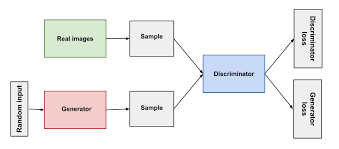


In [ ]:
from keras.layers import LeakyReLU

In [ ]:
### Lets define Generator network
def generator_model(optimizer) : 
  model = Sequential()
  model.add(Dense(128, input_dim = 118))
  model.add(Activation('tanh'))

  model.add(Dense(128))
  model.add(Activation('tanh'))

  model.add(Dense(256))
  model.add(Activation('tanh'))

  model.add(Dense(256))
  model.add(Activation('relu'))

  model.add(Dense(118))
  model.add(Activation('tanh'))

  model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

  return model

In [ ]:
### Lets define Descriminator network

def discriminator_model(optimizer) : 
  model = Sequential()
  model.add(Dense(256, input_dim = 118))
  model.add(LeakyReLU(alpha=0.5))
  model.add(Dropout(0.2))

  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.5))
  model.add(Dropout(0.2))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.5))
  model.add(Dropout(0.2))

  model.add(Dense(128))
  model.add(LeakyReLU(alpha=0.5))
  model.add(Dropout(0.2))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

  return model

In [ ]:
def gan_model(generator, discriminator, optimizer, input_dim=118): 
  discriminator.trainable = False

  inputTensor = Input(shape = (input_dim,))
  x = generator(inputTensor)

  outTensor = discriminator(x)

  model = Model(inputs = inputTensor, outputs = outTensor)
  model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

  return model

In [ ]:
epochs = 4
batch_size = 512
learning_rate = 0.00001

x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test']

adam = Adam(lr = learning_rate)

# create initial models:
generator = generator_model(adam)
discriminator = discriminator_model(adam)
gan = gan_model(generator, discriminator, adam, input_dim = 118)

batch_count = x_train.shape[0] // batch_size
print('Total batches: ', batch_count)

d_history = []
gan_history = []


for epoch in range(epochs):

    pbar = tqdm(total=batch_count)

    for index in range(batch_count):

      pbar.update(1)

      # fake results
      noise = np.random.normal(0, 1, size=[batch_size, 118])
      generated_batch_result = generator.predict_on_batch(noise)

      # normal results
      batch_start_index = index * batch_size
      batch_end_index = (index + 1) * batch_size
      normal_batch = x_train[batch_start_index:batch_end_index]

      # [generated_batch_result, normal_batch]
      # 0 - normal data
      # 1 - anomaly data

      y_batch_discriminator = np.ones(2 * batch_size)
      y_batch_discriminator[batch_size+1:] = 0
      x_batch_discriminator = np.concatenate((generated_batch_result,normal_batch))

      # Discriminator train part
      discriminator.trainable = True
      d_loss = discriminator.train_on_batch(x_batch_discriminator, y_batch_discriminator)

      # Generator part
      y_batch_generator = np.ones(batch_size)
      discriminator.trainable = False
      g_loss = gan.train_on_batch(noise, y_batch_generator)

      d_history.append(d_loss)
      gan_history.append(g_loss)

      pbar.set_description(f'[D loss: {d_loss}, G Loss: {g_loss}]');

    pbar.close();
    print(f'Epoch {epoch} done, [D loss: {d_loss}, G Loss: {g_loss}]');



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Total batches:  142


[D loss: 0.29549235105514526, G Loss: 0.2619227170944214]: 100%|██████████| 142/142 [00:13<00:00, 10.67it/s]


Epoch 0 done, [D loss: 0.29549235105514526, G Loss: 0.2619227170944214]


[D loss: 0.07319772243499756, G Loss: 0.03556504845619202]: 100%|██████████| 142/142 [00:11<00:00, 11.88it/s]


Epoch 1 done, [D loss: 0.07319772243499756, G Loss: 0.03556504845619202]


[D loss: 0.02917039394378662, G Loss: 0.009136292152106762]: 100%|██████████| 142/142 [00:12<00:00, 11.82it/s]


Epoch 2 done, [D loss: 0.02917039394378662, G Loss: 0.009136292152106762]


[D loss: 0.017658960074186325, G Loss: 0.0036329664289951324]: 100%|██████████| 142/142 [00:12<00:00, 11.81it/s]

Epoch 3 done, [D loss: 0.017658960074186325, G Loss: 0.0036329664289951324]


In [ ]:
predicted = discriminator.predict(x_test)

Text(0, 0.5, 'true positive rate')

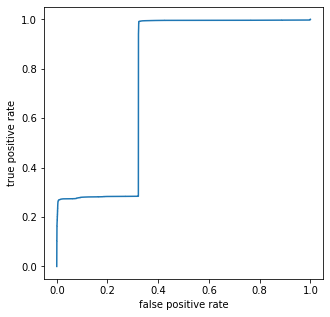

In [ ]:
roc_auc_score(y_test, predicted)
fpr, tpr, thr = roc_curve(y_test, predicted)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [ ]:
m = 10
temp = 0
for i in range(fpr.size):
    if (fpr[i] ** 2 + (tpr[i] - 1) ** 2 < m):
        m = fpr[i] ** 2 + (tpr[i] - 1) ** 2
        temp = i
print("OPTIMAL POINTS: ",fpr[temp],tpr[temp],thr[temp])

OPTIMAL POINTS:  0.3232785263938682 0.9910418283134654 0.017265648


In [ ]:
predicted_thr = []
threshold1 = 0.030794919
threshold2 = 0.017265648
for i in range(len(predicted)):
  if predicted[i] <= threshold2:
    predicted_thr.append(0)
  else:
    predicted_thr.append(1)


In [ ]:
matr = confusion_matrix(predicted_thr, y_test)
matr

array([[16422,   916],
       [ 7845, 98323]])

In [ ]:
(18827 + 97792)/(18827 + 97792+5440+1447)

0.944237526921769

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predicted_thr,y_test)

0.9290641750198371

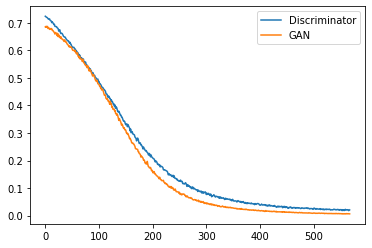

In [ ]:
plt.plot(d_history, label = 'Discriminator')
plt.plot(gan_history, label = 'GAN')
plt.legend()


Посмотрим что возвращает дискриминатор для noise (по идее он должен возвращать единицу, тк это аномальные данные типо они ничего не значат, но он возвращает 0 почему-то)

In [ ]:
noise = np.random.normal(0,1, size=[1,118])
discriminator.predict(noise)

array([[0.00950775]], dtype=float32)

In [ ]:
discriminator.predict(x_test[114].reshape(1,118))

array([[0.01877502]], dtype=float32)

In [ ]:
y_test[114]

0.0

In [ ]:
np.transpose(noise)

array([[ 5.02985159e-01],
       [ 5.68049059e-01],
       [-9.65948150e-01],
       [ 5.42641628e-01],
       [-4.16325834e-01],
       [-1.37917339e+00],
       [ 1.68700255e-01],
       [ 2.56646357e-01],
       [ 1.79144129e+00],
       [ 2.71257434e-02],
       [-9.40947106e-01],
       [-3.89901219e-01],
       [ 3.84709314e-01],
       [ 6.76537072e-01],
       [ 4.36258165e-01],
       [-1.34723647e+00],
       [ 1.27223502e-01],
       [ 4.77294813e-02],
       [ 9.57663801e-01],
       [ 1.21176154e-01],
       [-2.53690538e-01],
       [ 9.20279735e-02],
       [ 7.18991981e-01],
       [-1.59085953e+00],
       [ 8.45716346e-01],
       [ 3.29960347e-01],
       [ 1.45510946e+00],
       [ 4.83622821e-01],
       [ 2.50099555e-01],
       [-3.42162971e-01],
       [ 1.96449532e-01],
       [-7.19605722e-01],
       [-1.01480943e+00],
       [-3.62718925e-01],
       [ 9.38602471e-01],
       [ 2.72045839e-01],
       [ 2.81415906e-01],
       [ 8.30329782e-01],
       [-1.3

In [ ]:
noise.shape

(1, 118)

In [ ]:
dir(model)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_compute_oob_predictions',
 '_estimator_type',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_set_oob_score_and_attributes',
 '_validate_X_predict',
 '_validate_data',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'ccp_alpha',
 'class_weight'

In [ ]:
discriminator.get_weights()

[array([[-0.10681897,  0.06509662, -0.12226892, ..., -0.04451396,
         -0.02529427,  0.04006506],
        [ 0.07050513,  0.12347104, -0.04425992, ..., -0.01481659,
          0.11165528,  0.07644892],
        [ 0.04147387, -0.07582086,  0.07387277, ...,  0.07798139,
         -0.04144698,  0.04582482],
        ...,
        [ 0.06137419,  0.05749039,  0.02635726, ...,  0.02710763,
         -0.06968725,  0.03466322],
        [ 0.10916571, -0.04232114, -0.06875012, ..., -0.01516426,
          0.08211299, -0.07036979],
        [ 0.0293738 ,  0.04752425, -0.06767563, ..., -0.05417005,
          0.06817735, -0.02930328]], dtype=float32),
 array([ 7.6582520e-03,  1.7069288e-03, -5.7584872e-03, -3.8759077e-05,
         2.6731866e-03,  6.3898480e-03,  7.0605883e-03,  3.2476922e-03,
         1.3035565e-03, -2.6087004e-03,  3.6647462e-03,  4.3059005e-03,
         7.8110383e-03,  1.0307337e-03, -5.1831645e-03,  7.5550750e-04,
        -2.8100957e-03,  7.3564365e-03, -7.1523516e-03,  1.7025810e-03

In [ ]:
for lay in discriminator.layers:
    print(lay.name)
    print(lay.get_weights())

dense_5
[array([[-0.10681897,  0.06509662, -0.12226892, ..., -0.04451396,
        -0.02529427,  0.04006506],
       [ 0.07050513,  0.12347104, -0.04425992, ..., -0.01481659,
         0.11165528,  0.07644892],
       [ 0.04147387, -0.07582086,  0.07387277, ...,  0.07798139,
        -0.04144698,  0.04582482],
       ...,
       [ 0.06137419,  0.05749039,  0.02635726, ...,  0.02710763,
        -0.06968725,  0.03466322],
       [ 0.10916571, -0.04232114, -0.06875012, ..., -0.01516426,
         0.08211299, -0.07036979],
       [ 0.0293738 ,  0.04752425, -0.06767563, ..., -0.05417005,
         0.06817735, -0.02930328]], dtype=float32), array([ 7.6582520e-03,  1.7069288e-03, -5.7584872e-03, -3.8759077e-05,
        2.6731866e-03,  6.3898480e-03,  7.0605883e-03,  3.2476922e-03,
        1.3035565e-03, -2.6087004e-03,  3.6647462e-03,  4.3059005e-03,
        7.8110383e-03,  1.0307337e-03, -5.1831645e-03,  7.5550750e-04,
       -2.8100957e-03,  7.3564365e-03, -7.1523516e-03,  1.7025810e-03,
       

## Using whole dataset

In [ ]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz

--2021-11-20 09:44:44--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz.1’

kddcup.data.gz.1    100%[===================>]  17.28M  2.96MB/s    in 6.9s    

2021-11-20 09:44:51 (2.50 MB/s) - ‘kddcup.data.gz.1’ saved [18115902/18115902]



In [ ]:
!gzip -d /content/kddcup.data.gz

gzip: /content/kddcup.data already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
file_path = '/content/kddcup.data'
df = pd.read_csv(file_path, header=None, names=col_names, index_col=False)
df.head

<bound method NDFrame.head of          duration protocol_type  ... dst_host_srv_rerror_rate    label
0               0           tcp  ...                      0.0  normal.
1               0           tcp  ...                      0.0  normal.
2               0           tcp  ...                      0.0  normal.
3               0           tcp  ...                      0.0  normal.
4               0           tcp  ...                      0.0  normal.
...           ...           ...  ...                      ...      ...
4898426         0           tcp  ...                      0.0  normal.
4898427         0           tcp  ...                      0.0  normal.
4898428         0           tcp  ...                      0.0  normal.
4898429         0           tcp  ...                      0.0  normal.
4898430         0           tcp  ...                      0.0  normal.

[4898431 rows x 42 columns]>

In [ ]:
# and add one-hot-encoded columns
numerics_data = df[col_numerics].copy()
numerics_cat_data = pd.concat([numerics_data, cat_data] ,axis=1)

In [ ]:
labels = df['label'].copy()
transormed_labels = le.transform(labels)

In [ ]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,2,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.00,3,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.00,4,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,32,0.0,0.0,0.0,0.0,1.0,0.0,0.16,3,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,33,0.0,0.0,0.0,0.0,1.0,0.0,0.15,4,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,34,0.0,0.0,0.0,0.0,1.0,0.0,0.15,5,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,35,0.0,0.0,0.0,0.0,1.0,0.0,0.14,6,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


## Train-test split 

In [ ]:
# split dataset (with applied transforms) + labels 
# into train/test with 75% ratio

X_train, X_test, Y_train, Y_test = train_test_split(
    numerics_cat_data,
    transormed_labels,
    test_size = 0.25,
    random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3673823, 123)
(1224608, 123)
(3673823,)
(1224608,)


## RandomForest with full dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
%%time
model = RandomForestClassifier(n_estimators=300) 
model.fit(X_train, Y_train) 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [ ]:
from sklearn import tree
from os import system

estimator = model.estimators_[0] 
feature_names = [i for i in x_train.columns] 

tree.export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names, 
                rounded = True, 
                filled = True) 
 
#system.call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600']) 
 
#Image(filename = 'tree.png') 


In [ ]:
!dot -Tpng tree.dot -o tree.png

In [ ]:
y_predict = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
y_predict

array([ 5,  5,  5, ...,  5, 11, 11])

In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


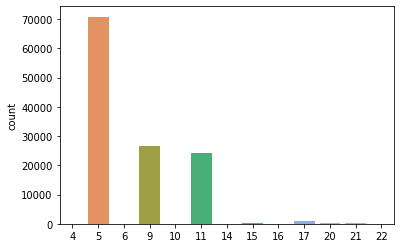

In [ ]:
sns.countplot(y_predict)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [ ]:
print(matr)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     1     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [  149 70651     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0 26709     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0    21     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [23599   734     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0    45     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [    0   285     0     0     0     0     0     0     0     0     0     0
      0     0     0]
 [   14     0     0     0     0     0     0     0 

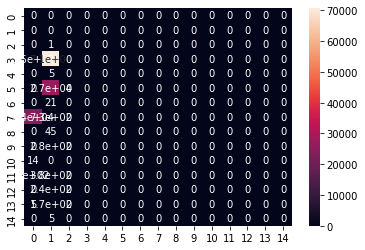

In [ ]:
matr = confusion_matrix(y_predict, y_test)
sn.heatmap(matr, annot=True)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

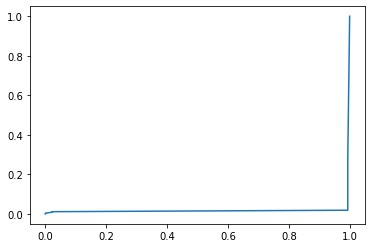

In [ ]:
roc_auc_score(y_test, y_predict)
fpr, tpr, thr = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)

In [ ]:
m = 10
temp = 0
for i in range(fpr.size):
    if (fpr[i] ** 2 + (tpr[i] - 1) ** 2 < m):
        m = fpr[i] ** 2 + (tpr[i] - 1) ** 2
        temp = i
print("OPTIMAL POINTS: ",fpr[temp],tpr[temp],thr[temp])

OPTIMAL POINTS:  0.0 0.7144973246405143 14


In [ ]:
y_predict

array([18, 18, 18, ..., 18, 11, 11])

In [ ]:
print(set(y_predict))

{0, 5, 9, 11, 14, 15, 17, 18, 20}


In [ ]:
y_test

array([1., 1., 1., ..., 1., 0., 0.], dtype=float32)